# Transfer learning(TL)

In [11]:
import tensorflow_datasets as tdfs

(train, test), info = tdfs.load("tf_flowers", split=["train[:80%]", "train[80%:]"], as_supervised=True, with_info=True)

info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='C:\\Users\\MaxF�rsntr�m-AI23GBG\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [12]:
info.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

img_shape: (333, 500, 3), label: 2
img_shape: (212, 320, 3), label: 3
img_shape: (240, 320, 3), label: 3
img_shape: (240, 320, 3), label: 4
img_shape: (317, 500, 3), label: 3
img_shape: (212, 320, 3), label: 0
img_shape: (240, 240, 3), label: 0
img_shape: (333, 500, 3), label: 0


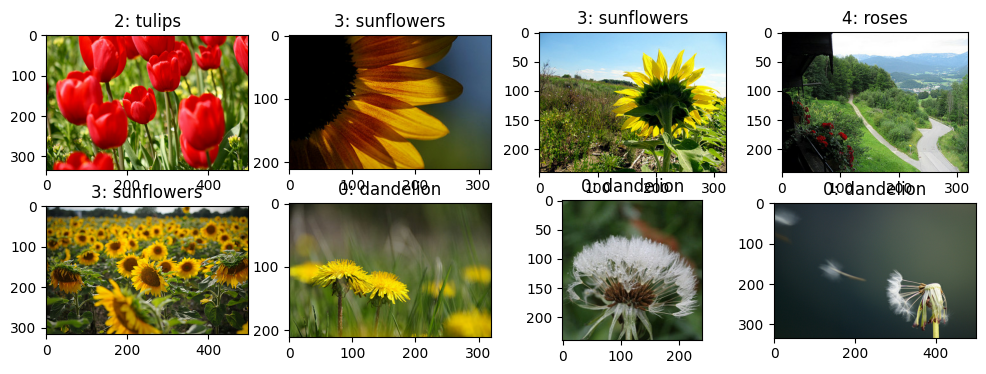

In [16]:
import matplotlib.pyplot as plt
label_names = info.features['label'].names
fig, axes = plt.subplots(2,4, figsize=(12,4))
for i, img_sample in enumerate(train.take(8)):
    print(f"img_shape: {img_sample[0].shape}, label: {img_sample[1]}")
    ax = axes.flatten()[i]
    ax.imshow(img_sample[0])
    ax.set_title(f"{img_sample[1]}: {label_names[img_sample[1]]}")

In [17]:
import tensorflow as tf
def preprocess_images(img, label, img_shape=(120, 120)):
    img = tf.image.resize(img, img_shape) / 255.0
    return img, label

input_shape = 120, 120, 3
batch_size = 32

train_batch = train.shuffle(buffer_size=600).map(preprocess_images).batch(batch_size).prefetch(1)
test_batch = test.map(preprocess_images).batch(batch_size).prefetch(1)

test_batch


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
from keras.applications import Xception

feature_extractor = Xception(weights="imagenet", include_top=False, input_shape=(input_shape))

In [19]:
import keras
from keras import layers

model = keras.Sequential([
    feature_extractor,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu", kernel_initializer="he_normal"),
    layers.Dropout(0.5),
    layers.Dense(5, activation="softmax")
])

for layer in  feature_extractor.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,387,309 (81.59 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
model.fit(train_batch, epochs=20, validation_data=test_batch)

In [ ]:
import pandas as pd
metrics = pd.DataFrame(model.history.history)

metrics[["loss", "val_loss"]].plot()

In [ ]:
metrics[["accuracy", "val_accuracy"]].plot()